# Vocalization analysis in live

TODO
- Titles / graduation etc
- same color everywere for f0
- understand the convolution

## Import

In [1]:
import os
import math
import glob
import librosa
import time
import libf0
import statistics
import numpy as np
import pandas as pd
from scipy import signal
from skimage.restoration import denoise_tv_chambolle
from scipy.io import wavfile
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
from scipy.stats import ttest_1samp
from scipy.stats import t

from ipywidgets import interact, interactive, fixed, interact_manual, IntSlider
import ipywidgets as widgets

C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


## Trigger and save by Avisoft

TODO

- check of every vocalization is triggered

## Import some data

In [2]:
basepath = "D:\\data\\playback2T01\\ch2"
listRecordingsPath = glob.glob(os.path.join(basepath, '*.wav'))

# Analysis step by step with interactive graphs

## Compute the fundamental frequency

In [3]:
def compute_and_show_f0(VocNumber, h, returnf0) :
    y, sr = librosa.load(listRecordingsPath[VocNumber], sr = 300000)
    
    f0,_,_= libf0.salience(y, Fs=sr, N=500, H=h, F_min=38000, F_max=90000, R=10.0, num_harm=10,
        freq_smooth_len=11, alpha=0.9, gamma=0.0, constraint_region=None, tol=5, score_low=0.01, score_high=1.0)
    times = librosa.times_like(f0, sr = sr,  hop_length = h)

    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)

    fig, ax = plt.subplots()

    img = librosa.display.specshow(D, x_axis='ms', y_axis='linear', ax=ax,  sr=sr, fmin=20000, fmax=100000)

    #ax.set(title='pYIN fundamental frequency estimation, duration = %f'%(duration))

    ax.set_ylim(20000, 100000)

    fig.colorbar(img, ax=ax, format="%+2.f dB")

    ax.plot(times, f0, label='f0', color='blue', linewidth=3)

    ax.legend(loc='upper right')
    
    if returnf0 :
        return f0,times

interact(compute_and_show_f0, VocNumber = IntSlider(min=0, max=25, step=1, value=10), h=IntSlider(min=50, max=1000, step=50, value=500), returnf0 = fixed(False))

interactive(children=(IntSlider(value=10, description='VocNumber', max=25), IntSlider(value=500, description='…

<function __main__.compute_and_show_f0(VocNumber, h, returnf0)>

## extract the vocalization

In [4]:
def find_and_show_steps(data, width, plot=False):
    dary = np.array(data)
    dary -= np.average(dary)
    step = np.hstack((np.ones(len(dary)), -1*np.ones(len(dary))))
    dary_step = np.convolve(dary, step, mode='valid')
    # Get the peaks of the convolution
    peaks = signal.find_peaks(dary_step, width=width)[0]
    
    # plots
    if plot :
        plt.plot(dary)
        plt.plot(dary_step/10)
        for ii in range(len(peaks)):
             plt.plot((peaks[ii], peaks[ii]), (min(min(dary_step/10), min(dary)) -2,max(max(dary),max(dary_step/10))+2), 'r')
        plt.ylim([min(min(dary_step/10), min(dary))-2,max(max(dary),max(dary_step/10))+2])
        plt.show()
    
    return peaks

def find_voc(VocNumber, weight, width, plot, h = 500, returnSteps = True) :
    f0,times = compute_and_show_f0(VocNumber=VocNumber, h=h, returnf0 = True)
    plt.close()
    x = np.array(f0)
    #plt.plot(f0)
    x_std = (x - x.mean()) / x.std()
    x_denoiseP = (denoise_tv_chambolle(x_std, weight= weight))**2
    x_denoiseN = -(denoise_tv_chambolle(x_std, weight= weight))**2
    
    stepsP = find_and_show_steps(x_denoiseP, width, plot)
    stepsN = find_and_show_steps(x_denoiseN, width, plot)
    
    if returnSteps :
        return [stepsP, stepsN,f0,times]
    
    
interact(find_voc, VocNumber=4, weight=IntSlider(min=1, max=10, step=1, value=0.5), 
        width=IntSlider(min=2, max=30, step=2, value=10),
        plot = fixed(True),
        returnSteps = fixed(False))

interactive(children=(IntSlider(value=4, description='VocNumber', max=12, min=-4), IntSlider(value=1, descript…

<function __main__.find_voc(VocNumber, weight, width, plot, h=500, returnSteps=True)>

In [5]:
def extract_vocalizationf0(VocNumber, noise_threshold, plot, h = 500):
    stepsP, stepsN, f0, times = find_voc(VocNumber, weight = 0.5, width = 10, h = h, plot = False)
    vocf0 = []
    voctime = []
    vocduration = [0]
    for i in range(min(len(stepsP), len(stepsN))):
        if np.mean(f0[stepsP[i]:stepsN[i]]) < noise_threshold :
            continue
        vocf0.append(list(f0[stepsP[i]:stepsN[i]]))
        voctime.append(list(times[stepsP[i]:stepsN[i]]))
        vocduration.append((times[stepsN[i]]) - times[stepsP[i]])

    Name = listRecordingsPath[VocNumber].split("_")[-1].split(".")[0]
    
    y, sr = librosa.load(listRecordingsPath[VocNumber], sr = 300000)
    if plot :
        fig = plt.figure(figsize = (10,6))
        ax = plt.gca()
        D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
        img = librosa.display.specshow(D, x_axis='ms', y_axis='linear', ax=ax,  sr=sr, fmin=20000, fmax=100000, cmap=None)
        #ax.set(title='fundamental frequency estimation,\n duration estimation = %f ms'%(vocduration[-1]))
        ax.set_ylim(20000, 100000)
        fig.colorbar(img, ax=ax, format="%+2.f dB")
        for vocnumber in range(len(vocf0)) :
            ax.plot(voctime[vocnumber], vocf0[vocnumber], label='f0', color='red', linewidth=2, linestyle = '-')
        ax.legend(loc='upper right')
       
interact(extract_vocalizationf0, VocNumber=4, noise_threshold=IntSlider(min=20000, max=70000, step=5000, value=45000), plot = fixed(True), 
         h=IntSlider(min=50, max=1200, step=50, value=500))

interactive(children=(IntSlider(value=4, description='VocNumber', max=12, min=-4), IntSlider(value=45000, desc…

<function __main__.extract_vocalizationf0(VocNumber, noise_threshold, plot, h=500)>

# The general function

In [6]:
def ExtractRecordingsPaths(playback_time_str, basepath) :
    """return a list of wavefiles paths"""
    # TODO : check that it's working
    playback_time = time.strptime(playback_time_str, '%H-%M-%S')
    listRecordingsPaths = glob.glob(os.path.join(basepath, '*.wav'))
    listgoodtime = []
    for RecordingPath in listRecordingsPaths :
        recording_time_str = RecordingPath.split('_')[-2]
        recording_time = time.strptime(recording_time_str, '%H-%M-%S')
        if playback_time < recording_time : #on peut aussi ajouter un seuil pour que ce ne soit pas trop longtemps après ??
            listgoodtime.append(RecordingPath)
    return listgoodtime

In [7]:
def find_steps(data, width = 10) :
    dary = np.array(data)
    dary -= np.average(dary)
    step = np.hstack((np.ones(len(dary)), -1*np.ones(len(dary))))
    dary_step = np.convolve(dary, step, mode='valid')
    # Get the peaks of the convolution
    peaks = signal.find_peaks(dary_step, width=width)[0]
    return peaks


def process_single_audio(file_path, h, fmin,n=500, weight = 0.5, width = 10, tol = 5, completef0 = False,):

    try:
        y, sr = librosa.load(file_path, sr = 300000) # important, garder cette frequence d'echantillognage, sinon faux.

        #y = nr.reduce_noise(y1, sr, hop_length = 512, freq_mask_smooth_hz = 1000)
        f0,_,_= libf0.salience(y, Fs=sr, N=n, H=h, F_min=fmin, F_max=90000, R=10.0, num_harm=10, 
                               freq_smooth_len=11, alpha=0.9, gamma=0.0, constraint_region=None, tol=tol, score_low=0.01, score_high=1.0)
        times = librosa.times_like(f0, sr = sr,  hop_length = h)

        #very depend of the F thresholds

        # Convolution part
        # denoising the extimated f0
        x = np.array(f0)
        x_std = (x - x.mean()) / x.std()
        x_denoiseP = (denoise_tv_chambolle(x_std, weight= weight))**2
        x_denoiseN = -(denoise_tv_chambolle(x_std, weight= weight))**2
        # find the steps
        stepsP = find_steps(x_denoiseP, width)
        stepsN = find_steps(x_denoiseN, width)

        vocf0 = []
        voctime = []
        vocduration = []
        voctotf0 = []
        # for each vocalization found in the audio
        for i in range(min(len(stepsP), len(stepsN))):
            if np.mean(f0[stepsP[i]:stepsN[i]]) < 45000 :
                continue
            vocf0.append(np.mean(f0[stepsP[i]:stepsN[i]]))
            voctotf0.append(f0[stepsP[i]:stepsN[i]])
            voctime.append(list(times[stepsP[i]:stepsN[i]]))
            vocduration.append(times[stepsN[i]] - times[stepsP[i]])
        if not vocf0 :
            return None
        if completef0 :
            return {
            'Filename': [file_path.split("_")[-1].split(".")[0]]*len(vocf0),
            'F0' : voctotf0,
            'Duration' : voctime
        }
        return {
            'Filename': [file_path.split("_")[-1].split(".")[0]]*len(vocf0),
            'F0' : vocf0,
            'Duration' : vocduration
        }
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

In [8]:
def ExtractFeaturesRecordings(file_paths, h, fmin,n=500,weight=0.5, width=10, tol=5):
    results = {
            'Filename': [],
            'Frequency' : [],
            'Duration' : [],
        }

    for file_path in file_paths:
        result = process_single_audio(file_path, h, fmin,n, weight, width,tol,completef0 = False,)
        if result is not None:
            results['Filename'].extend(result['Filename'])
            results['Frequency'].extend(result['F0'])
            results['Duration'].extend(result['Duration'])

    df = pd.DataFrame(results)
    df = df.dropna(axis=0, how='any')
    return df

In [9]:
def VocAnalysis(playback_time_str, basepath, Feature = "VocNumber", thresholds = [0, 100], h=500, fmin=40000) :
    # TODO : check for method error. (try, except)
    listRecordingsPaths = ExtractRecordingsPaths(playback_time_str, basepath)
    if len(listRecordingsPaths) == 0 :
        return False
    FeaturesDF = ExtractFeaturesRecordings(listRecordingsPaths, h, fmin)
    if Feature == "VocNumber" :
        if (len(FeaturesDF) >= min(thresholds) and len(FeaturesDF) < max(thresholds)) :
            return True
    elif Feature == "Duration" or Feature == "Frequency":
        if any(FeaturesDF[Feature] >= min(thresholds)) and any(FeaturesDF[Feature] < max(thresholds)) :
            return True
    return False

In [10]:
playback_time_str = '15-41-48'

In [11]:
start = time.perf_counter()

print(VocAnalysis(playback_time_str, basepath, Feature = "Frequency", thresholds = [60000, 70000],fmin=40000))

finish = time.perf_counter()
print(f'It took {finish-start:.2f} second(s) to finish')

C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)


True
It took 0.65 second(s) to finish


## Execution time depending on some parameters

C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)


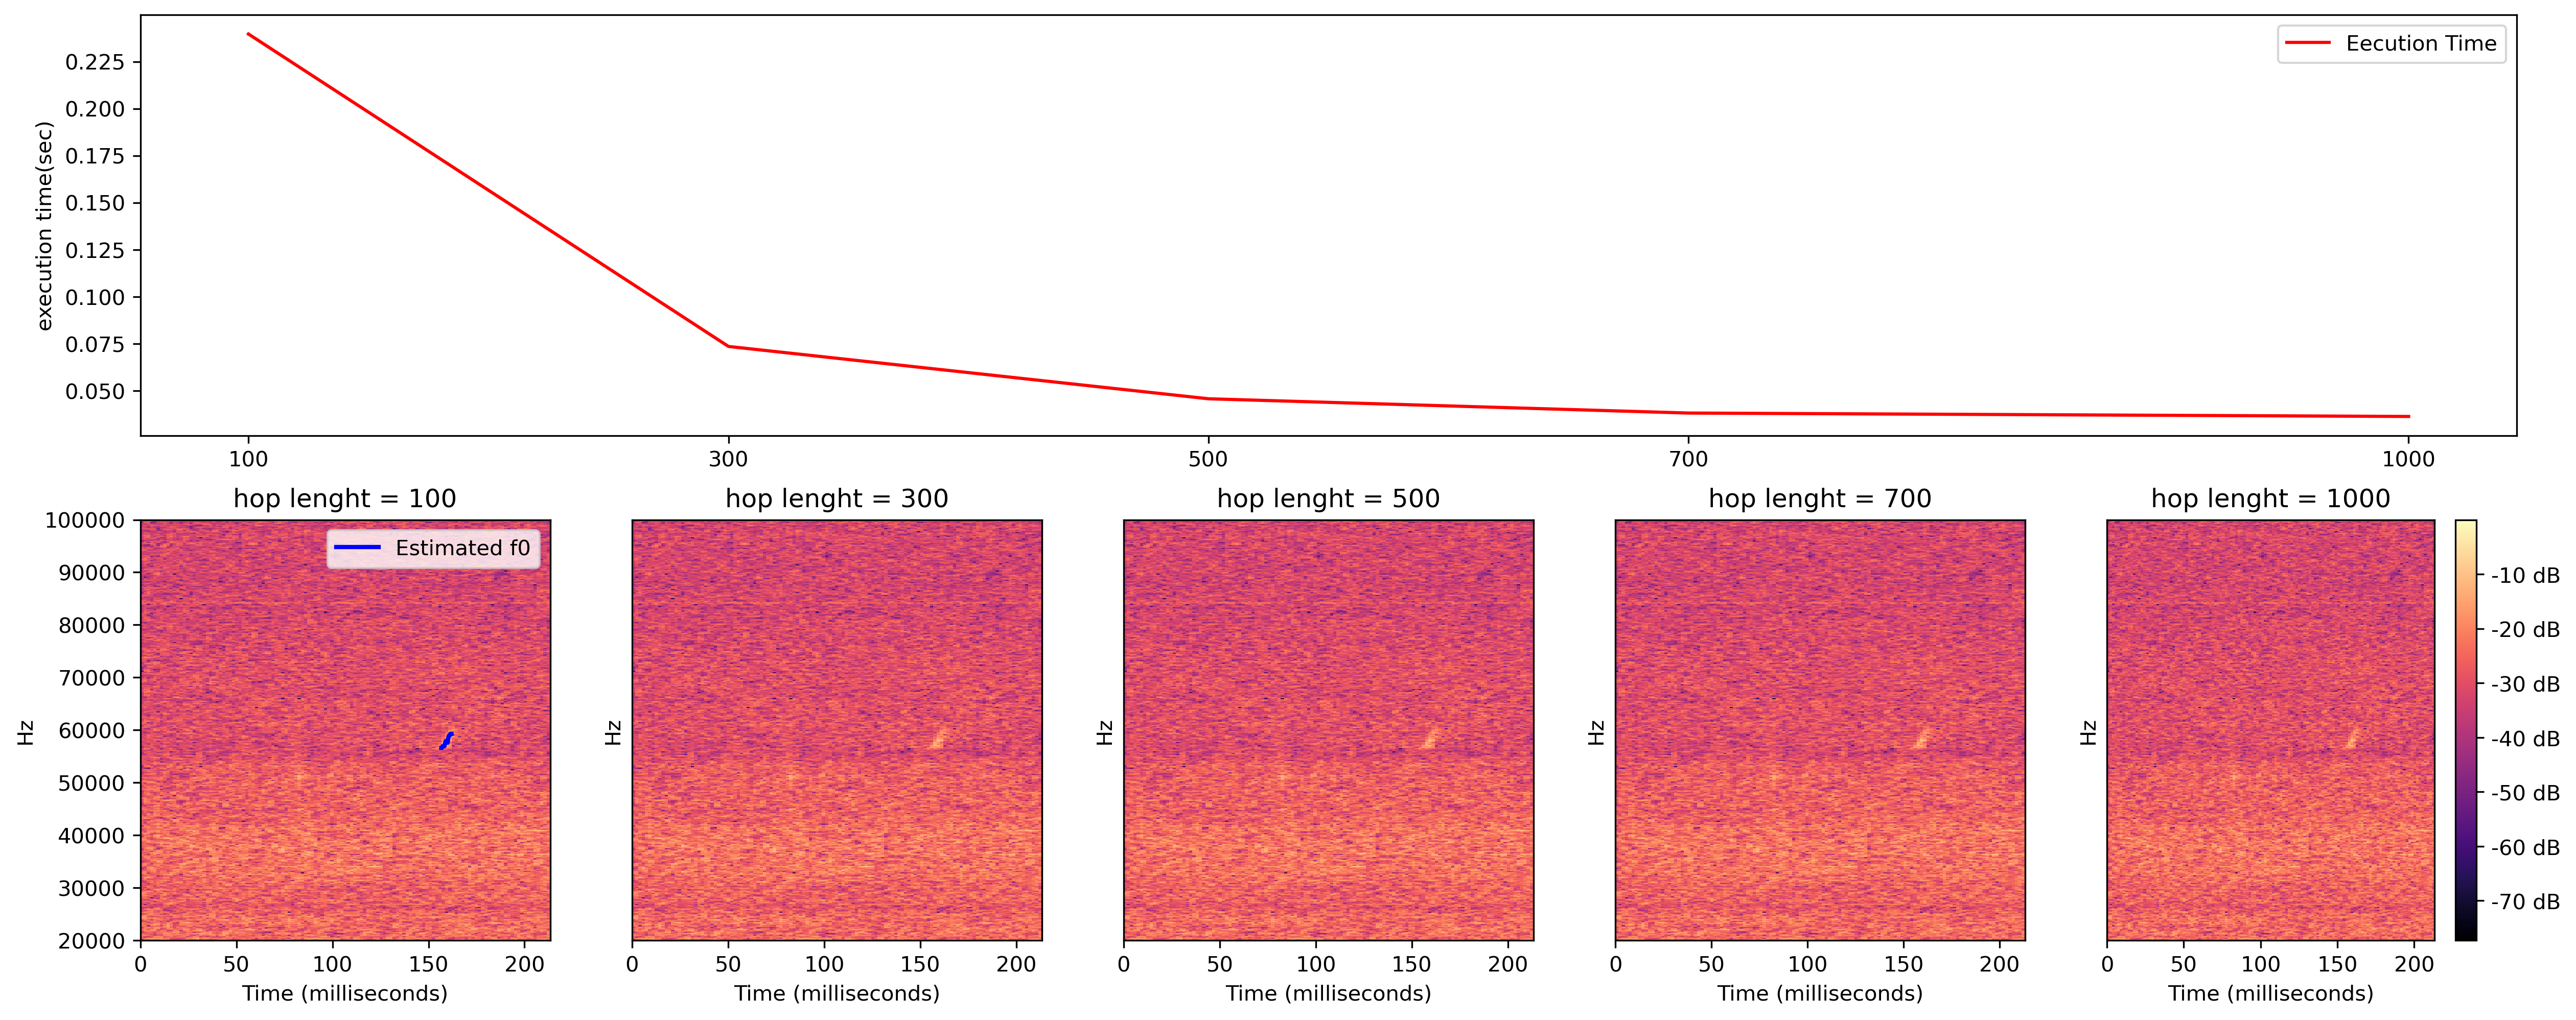

In [29]:
playback_time_str = '15-00-00'
file_paths = ExtractRecordingsPaths(playback_time_str, basepath)
testH = [100, 300, 500, 700, 1000]
execution_time = []
gs = gridspec.GridSpec(2, len(testH), plt.figure(figsize = (20,8), dpi=300))

for i in range(len(testH)) :
    h = testH[i]
    start = time.perf_counter()
    singledf = process_single_audio(file_paths[8], h, fmin=38000, completef0 = True)
    finish = time.perf_counter()
    execution_time.append(finish-start)
    
    ax = plt.subplot(gs[1,i])
    y, sr = librosa.load(file_paths[8], sr = 300000)
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
    img = librosa.display.specshow(D, x_axis='ms', y_axis='linear', ax=ax,  sr=sr, fmin=20000, fmax=100000)
    if i != 0 :
        ax.set_yticks([])
    ax.set(title='hop lenght = %d'%(h))
    ax.set_ylim(20000, 100000)
    if singledf :
        for vocnumber in range(len(singledf['F0'])) :
            ax.plot(singledf['Duration'][vocnumber], singledf['F0'][vocnumber], label='Estimated f0', color='blue', linewidth=2, linestyle = '-')
    if i == 0:
        ax.legend()
plt.colorbar(img, ax=ax, format="%+2.f dB")
ax = plt.subplot(gs[0,:])
ax.plot(testH, execution_time, color='r', label = "Eecution Time")
ax.set_xticks(testH)
ax.set_ylabel("execution time(sec)")
ax.legend()

plt.savefig("C:\\Users\\de Witasse Thézy\\Documents\\ENS\\cours_ENS\\M2\\MoBi\\projet\\report\\littlevoc.png")


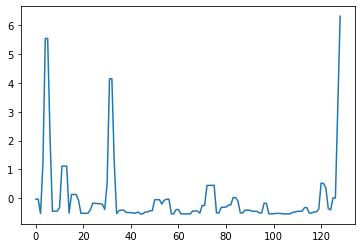

In [30]:
f0,_,_= libf0.salience(y, Fs=sr, N=500, H=500, F_min=40000, F_max=90000, R=10.0, num_harm=10,
        freq_smooth_len=11, alpha=0.9, gamma=0.0, constraint_region=None, tol=5, score_low=0.01, score_high=1.0)
x = np.array(f0)
x_std = (x - x.mean()) / x.std()
data = (denoise_tv_chambolle(x_std, weight= 0.5))**2
dary = np.array(data)
dary -= np.average(dary)
plt.plot(dary)
#plt.plot(np.hstack((-1*np.ones(len(dary)), np.ones(len(dary)))))

### Confusion matrix



In [31]:
confusion_1M = [[25,0],[4,6]]
confusion_1P = [[50,1],[4,14]]
confusion_2P = [[16,0],[1,5]]
confusion_matrices = [confusion_1M, confusion_1P, confusion_2P]
standard_confusion_matrices = [confusion_1M/np.sum(confusion_1M), 
                             confusion_1P/np.sum(confusion_1P), 
                             confusion_2P/np.sum(confusion_2P)]

In [32]:
def estim_accuracy(confusion_matrix):
    return ((confusion_matrix[0][0]+confusion_matrix[1][1])/np.sum(confusion_matrix))

def estim_precision(confusion_matrix):
    return (confusion_matrix[0][0]/np.sum(confusion_matrix[0]))

def estim_detection(confusion_matrix):
    return (confusion_matrix[0][0]/(confusion_matrix[0][0]+confusion_matrix[1][0]))

0.9225986573812661
0.06087210184559239
0.4226497308103764
0.0650872932730147


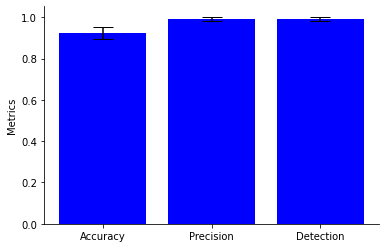

In [33]:
def calculate_metrics(confusion_matrices):
    accuracies = []
    precisions = []
    detections = []

    for matrix in confusion_matrices:
        accuracies.append(estim_accuracy(matrix))
        precisions.append(estim_precision(matrix))
        detections.append(estim_detection(matrix))

    return accuracies, precisions, detections

def plot_metrics(accuracies, precisions, detections):
    fig, ax = plt.subplots()

    # Plot mean and standard deviation of accuracy
    mean_acc = np.mean(accuracies)
    print(mean_acc)
    std_acc = np.std(accuracies)
    ax.bar('Accuracy', mean_acc, yerr=std_acc, capsize=10, label='Accuracy', color = "blue")

    # Plot mean and standard deviation of precision
    mean_prec = np.mean(precisions)
    std_prec = np.std(precisions)
    ax.bar('Precision', mean_prec, yerr=std_prec, capsize=10, label='Precision', color = "blue")
    
    # Plot mean and standard deviation of precision
    mean_det = np.mean(detections)
    std_det = np.std(detections)
    ax.bar('Detection', mean_prec, yerr=std_prec, capsize=10, label='Detection', color = "blue")
    
    alpha = 0.05  # significance level

    _, p_value_acc = ttest_1samp(accuracies, 1)
    if p_value_acc < alpha:
        ax.text(0, mean_acc + 0.1, '*', ha='center', va='bottom', fontsize=15)
    print(p_value_acc)
    
    _, p_value_prec = ttest_1samp(precisions, 1)
    if p_value_prec < alpha:
        ax.text(1, mean_prec + 0.1, '*', ha='center', va='bottom', fontsize=15)
    print(p_value_prec)
    
    _, p_value_det = ttest_1samp(detections, 1)
    if p_value_det < alpha:
        ax.text(1, mean_det + 0.1, '*', ha='center', va='bottom', fontsize=15)
    print(p_value_det)

    ax.set_ylabel('Metrics')
    #ax.set_title('Mean and Standard Deviation of Accuracy and Precision')
    #ax.legend()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.show()

accuracies, precisions, detections = calculate_metrics(confusion_matrices)
plot_metrics(accuracies, precisions, detections)

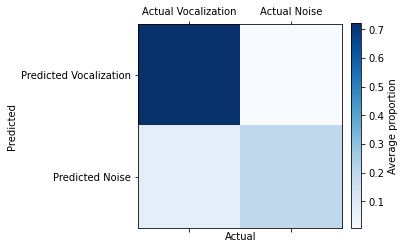

In [34]:
def plot_average_confusion_matrix_matplotlib(standard_confusion_matrices):
    # Calculate the average confusion matrix
    avg_matrix = np.mean(standard_confusion_matrices, axis=0)

    # Plot the heatmap
    #plt.figure(figsize=(8, 6))
    cax = plt.matshow(avg_matrix, cmap='Blues')
    plt.colorbar(cax, fraction=0.046, pad=0.04, label = "Average proportion")

    # Add labels and title
    #plt.title('Average Confusion Matrix')
    plt.ylabel('Predicted')
    plt.xlabel('Actual')
    plt.yticks([0, 1], ['Predicted Vocalization', 'Predicted Noise'])
    plt.xticks([0, 1], ['Actual Vocalization', 'Actual Noise'])

    plt.show()
plot_average_confusion_matrix_matplotlib(standard_confusion_matrices)

In [35]:
execution_time = []
basepaths = ["D:\\data\\playback2T01\\ch2", "D:\\data\\playbackT01\\ch2", "D:\\data\\1MouseT05\\ch2"]
for basepath in basepaths :
    listRecordingsPath = glob.glob(os.path.join(basepath, '*.wav'))
    start = time.perf_counter()
    ExtractFeaturesRecordings(listRecordingsPath, h=600, fmin=38000)
    finish = time.perf_counter()
    execution_time.append((finish-start)/len(listRecordingsPath))
    
print(np.mean(execution_time))

C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.044903452015250776


In [36]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

def calculate_snr(audio_file_path):
    # Load the audio file
    y, sr = librosa.load(audio_file_path)

    # Extract the power of the signal
    signal_power = np.sum(y**2)

    # Generate white noise of the same length as the audio
    noise = np.random.normal(0, 1, len(y))

    # Extract the power of the noise
    noise_power = np.sum(noise**2)

    # Calculate SNR in decibels
    snr_db = 10 * np.log10(signal_power / noise_power)

    return snr_db

def plot_audio_waveform(audio_file_path):
    # Load the audio file
    y, sr = librosa.load(audio_file_path)

    # Plot the audio waveform
    plt.figure(figsize=(10, 4))
    librosa.display.waveshow(y, sr=sr)
    plt.title('Audio Waveform')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.show()

for audio_file_path in listRecordingsPath :

    # Calculate and print SNR
    snr = calculate_snr(audio_file_path)
    print(f'SNR: {snr:.2f} dB')

    # Plot the audio waveform
    #plot_audio_waveform(audio_file_path)


SNR: -67.00 dB
SNR: -67.01 dB
SNR: -67.48 dB
SNR: -66.38 dB
SNR: -60.92 dB
SNR: -59.61 dB
SNR: -50.14 dB
SNR: -55.95 dB
SNR: -65.90 dB
SNR: -65.39 dB
SNR: -57.83 dB
SNR: -56.33 dB
SNR: -67.20 dB
SNR: -64.55 dB
SNR: -64.85 dB
SNR: -65.94 dB
SNR: -65.75 dB
SNR: -65.42 dB
SNR: -67.92 dB
SNR: -68.15 dB
SNR: -67.48 dB
SNR: -67.24 dB
SNR: -67.17 dB
SNR: -66.17 dB
SNR: -67.47 dB
SNR: -57.68 dB
SNR: -59.90 dB
SNR: -66.90 dB
SNR: -67.31 dB
SNR: -66.79 dB
SNR: -46.12 dB
SNR: -57.75 dB
SNR: -64.59 dB
SNR: -63.49 dB


C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)


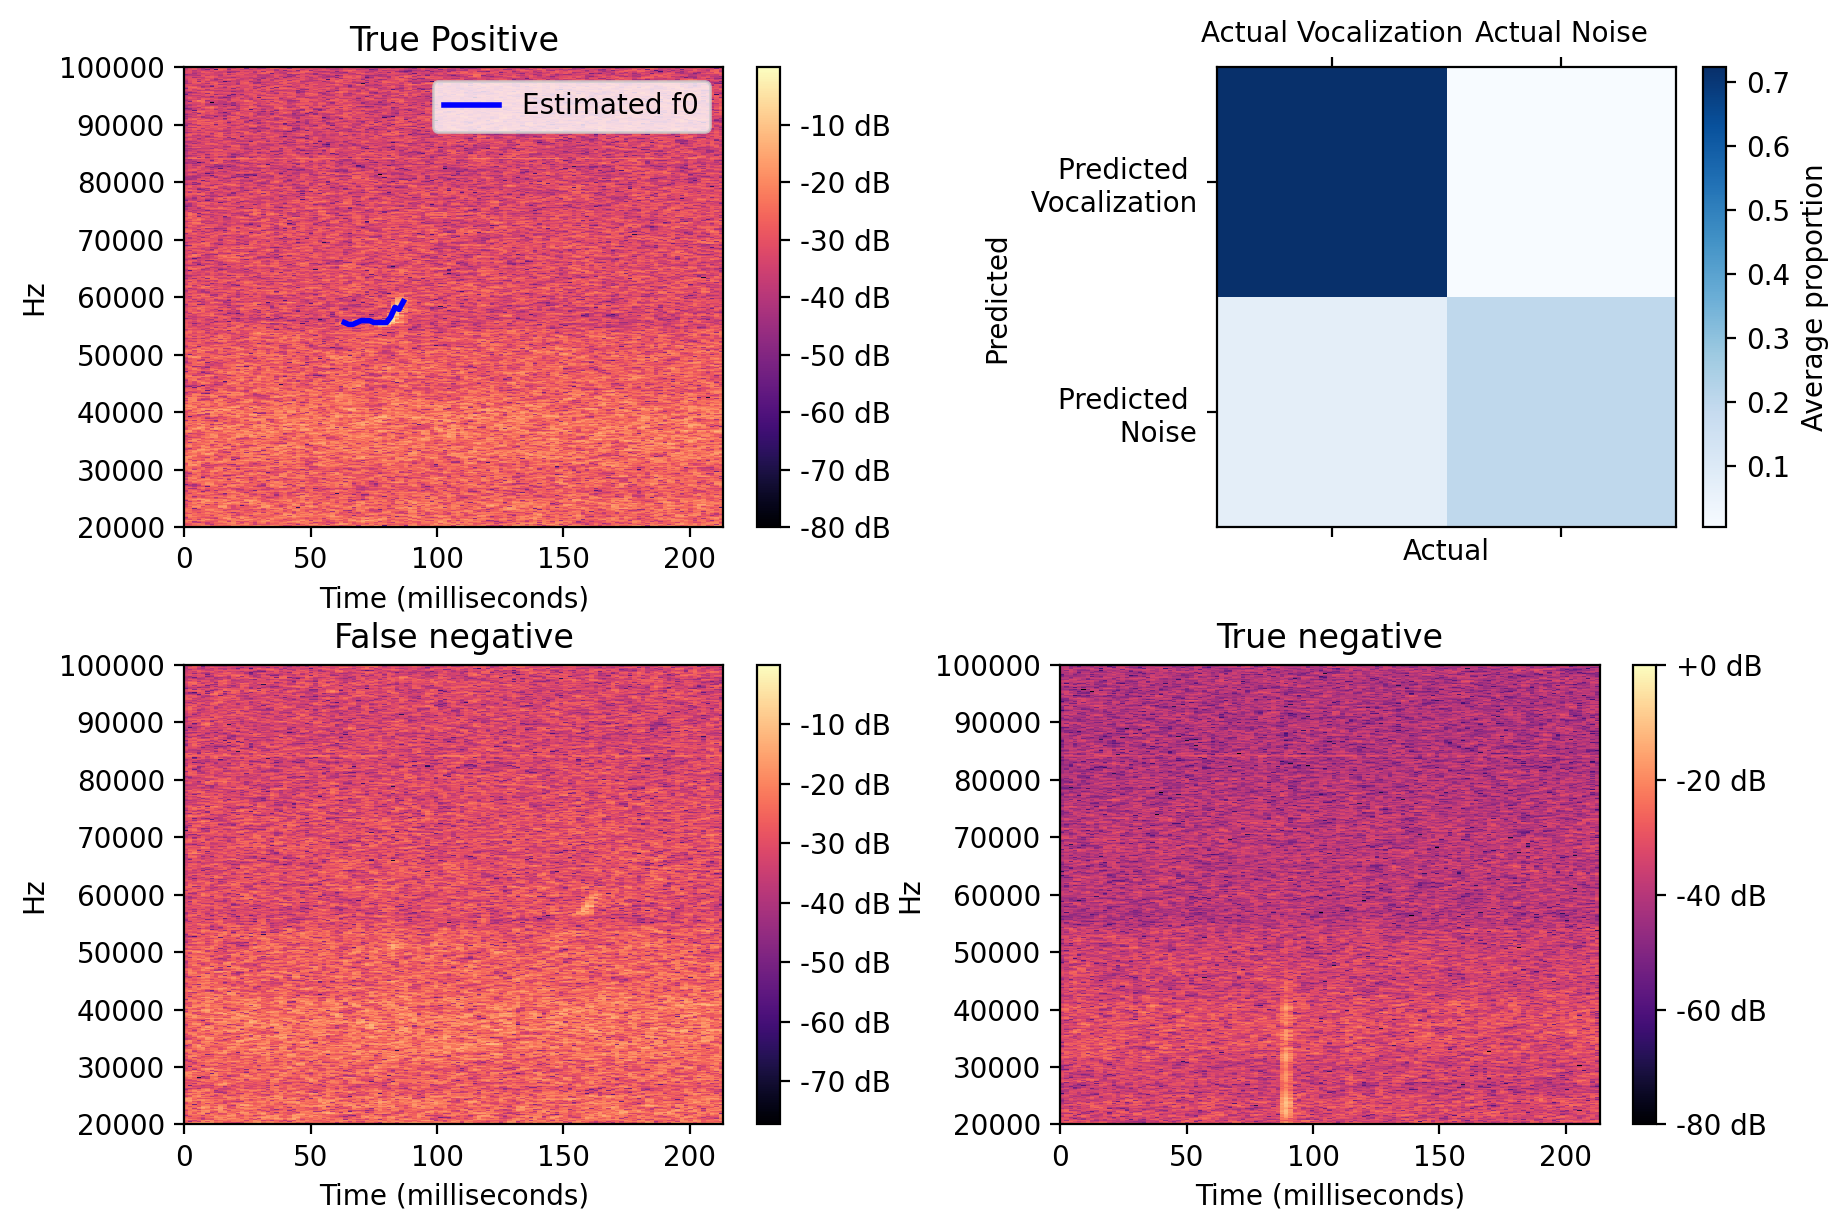

In [37]:
h = 500

gs = gridspec.GridSpec(2, 2, plt.figure(figsize = (10,7), dpi=200), wspace=0.3, hspace = 0.3)
ax = plt.subplot(gs[0,1], anchor = 'W')
# Calculate the average confusion matrix
avg_matrix = np.mean(standard_confusion_matrices, axis=0)

# Plot the heatmap
#plt.figure(figsize=(8, 6))
cax = ax.matshow(avg_matrix, cmap='Blues')
plt.colorbar(cax, fraction=0.046, pad=0.04, label = "Average proportion")

# Add labels and title
#plt.title('Average Confusion Matrix')
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.yticks([0, 1], ['Predicted \n Vocalization', 'Predicted \n Noise'])
plt.xticks([0, 1], ['Actual Vocalization', 'Actual Noise'])

### TRUE POSITIVE
singledf = process_single_audio(file_paths[3], h,fmin=40000, completef0 = True)
ax = plt.subplot(gs[0,0])
y, sr = librosa.load(file_paths[3], sr = 300000)
D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
img = librosa.display.specshow(D, x_axis='ms', y_axis='linear', ax=ax,  sr=sr, fmin=20000, fmax=100000, cmap='magma')
ax.set(title='True Positive')
ax.set_ylim(20000, 100000)
if singledf :
    for vocnumber in range(len(singledf['F0'])) :
        ax.plot(singledf['Duration'][vocnumber], singledf['F0'][vocnumber], label='Estimated f0', color='blue', linewidth=2, linestyle = '-')
plt.colorbar(img, ax=ax, format="%+2.f dB")
ax.legend(loc='upper right')

### FALSE NEGATIVE
singledf = process_single_audio(file_paths[8], h,fmin=40000, completef0 = True)
ax = plt.subplot(gs[1,0])
y, sr = librosa.load(file_paths[8], sr = 300000)
D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
img = librosa.display.specshow(D, x_axis='ms', y_axis='linear', ax=ax,  sr=sr, fmin=20000, fmax=100000, cmap='magma')
ax.set(title='False negative')
ax.set_ylim(20000, 100000)
if singledf :
    for vocnumber in range(len(singledf['F0'])) :
        ax.plot(singledf['Duration'][vocnumber], singledf['F0'][vocnumber], label='Estimated f0', color='blue', linewidth=2, linestyle = '-')
plt.colorbar(img, ax=ax, format="%+2.f dB")

### TRUE NEGATIVE
singledf = process_single_audio(file_paths[25], h,fmin=40000, completef0 = True)
ax = plt.subplot(gs[1,1])
y, sr = librosa.load(file_paths[25], sr = 300000)
D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
img = librosa.display.specshow(D, x_axis='ms', y_axis='linear', ax=ax,  sr=sr, fmin=20000, fmax=100000, cmap='magma')
ax.set(title='True negative')
ax.set_ylim(20000, 100000)
if singledf :
    for vocnumber in range(len(singledf['F0'])) :
        ax.plot(singledf['Duration'][vocnumber], singledf['F0'][vocnumber], label='Estimated f0', color='blue', linewidth=2, linestyle = '-')
plt.colorbar(img, ax=ax, format="%+2.f dB")


#ax = plt.subplot(gs[1,0])

# Plot mean and standard deviation of accuracy
#mean_acc = np.mean(accuracies)
#std_acc = np.std(accuracies)
#ax.bar('Accuracy', mean_acc, yerr=std_acc, capsize=10, label='Accuracy', color = "darkblue")

# Plot mean and standard deviation of precision
#mean_prec = np.mean(precisions)
#std_prec = np.std(precisions)
#ax.bar('Precision', mean_prec, yerr=std_prec, capsize=10, label='Precision', color = "darkblue")#

# Plot mean and standard deviation of precision
#mean_det = np.mean(detections)
#std_det = np.std(detections)
#ax.bar('Detection', mean_prec, yerr=std_prec, capsize=10, label='Detection', color = "darkblue")

#ax.set_ylabel('Metrics')
#ax.set_title('Mean and Standard Deviation of Accuracy and Precision')
#ax.legend()
#ax.spines['top'].set_visible(False)
#ax.spines['right'].set_visible(False)

plt.show()



C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)


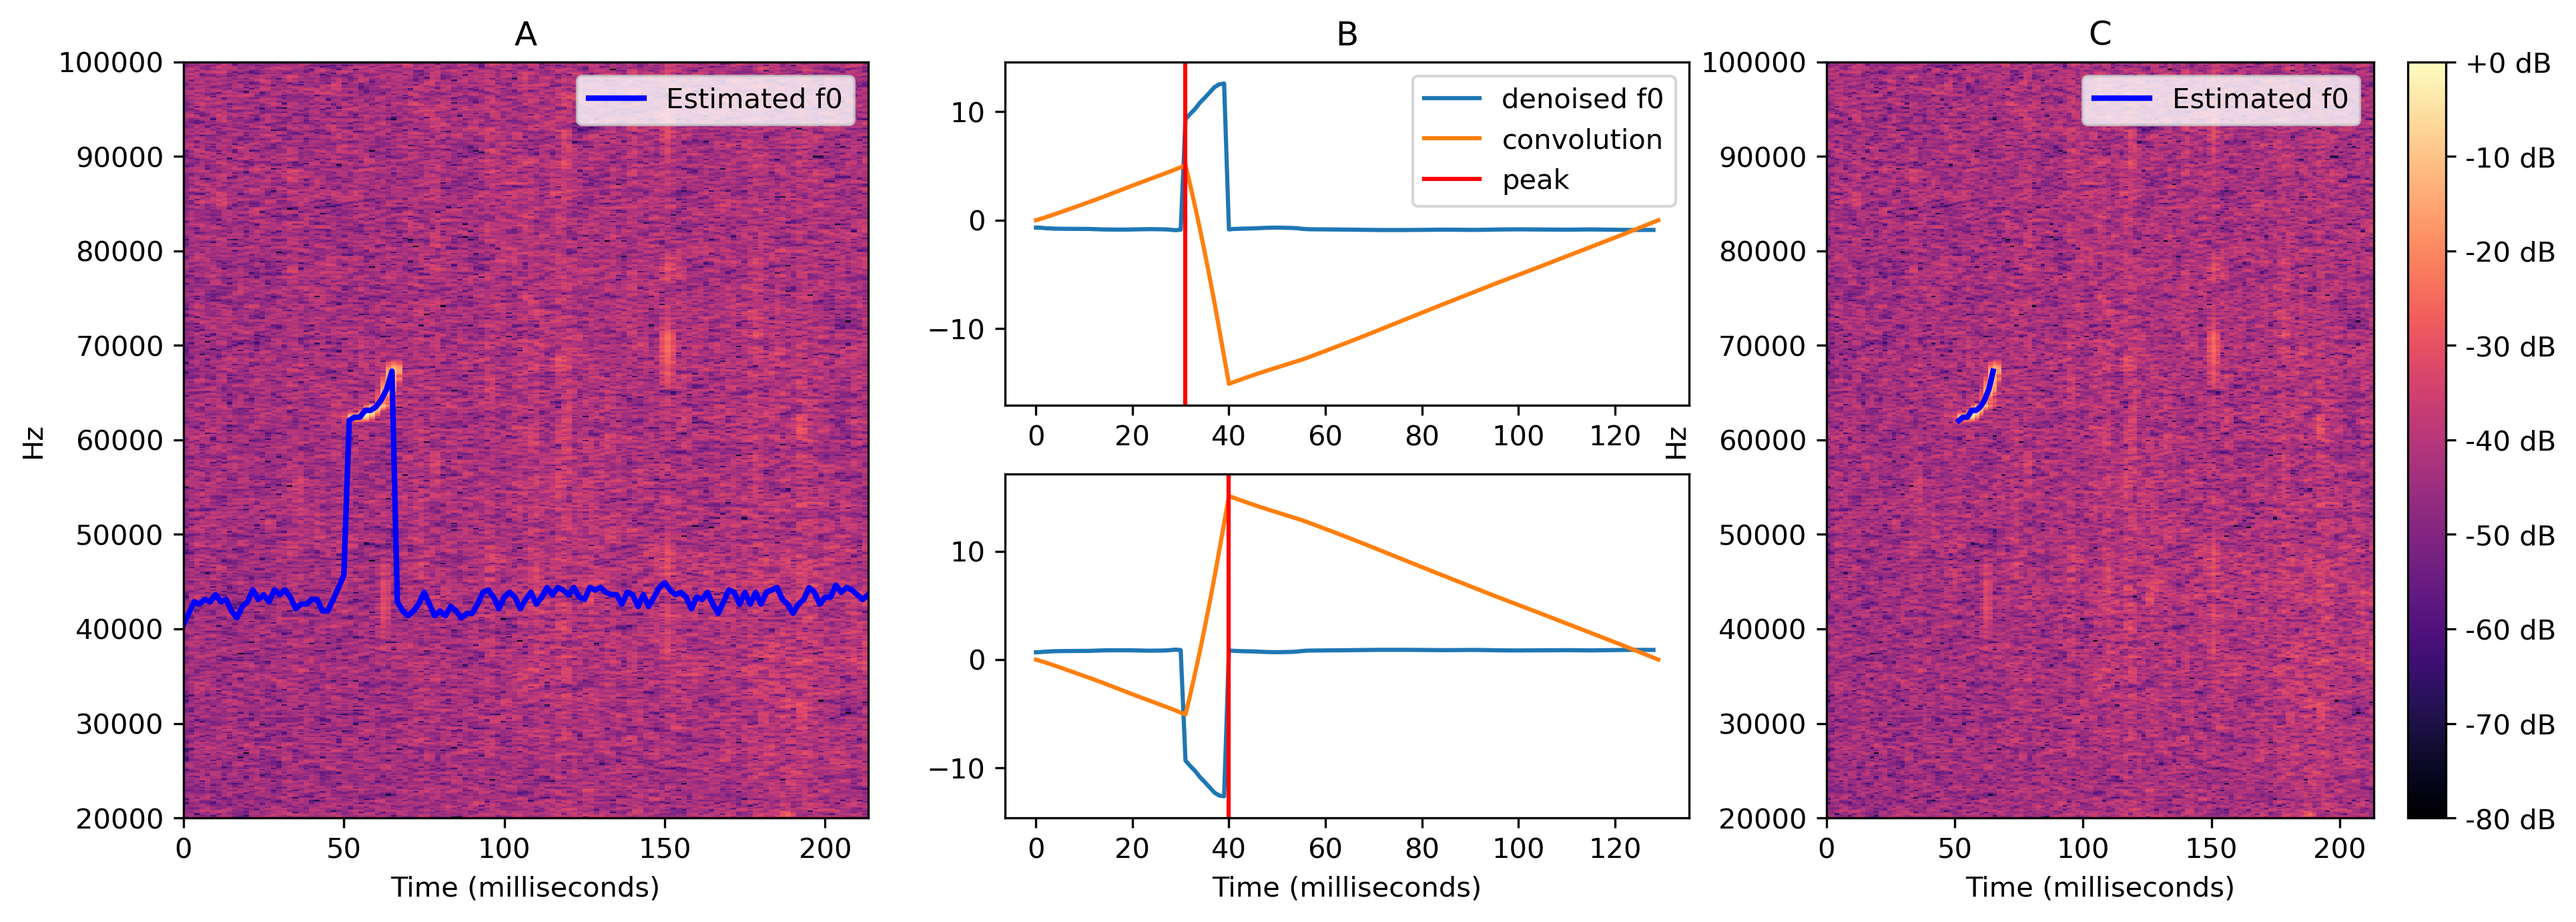

In [39]:
VocNumber = 12
h = 500

gs = gridspec.GridSpec(2, 3, plt.figure(figsize = (15,5), dpi=300))
### all
ax = plt.subplot(gs[:,0])

y, sr = librosa.load(listRecordingsPath[VocNumber], sr = 300000)
f0,_,_= libf0.salience(y, Fs=sr, N=500, H=h, F_min=40000, F_max=90000, R=10.0, num_harm=10,
    freq_smooth_len=11, alpha=0.9, gamma=0.0, constraint_region=None, tol=5, score_low=0.01, score_high=1.0)
times = librosa.times_like(f0, sr = sr,  hop_length = h)
D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
img = librosa.display.specshow(D, x_axis='ms', y_axis='linear', ax=ax,  sr=sr, fmin=20000, fmax=100000)
#ax.set(title='pYIN fundamental frequency estimation, duration = %f'%(duration))
ax.set_ylim(20000, 100000)
ax.plot(times, f0, label='Estimated f0', color='blue', linewidth=2)
ax.legend(loc='upper right')
ax.set(title='A')
    
### convolution
width = 10
weight = 0.5

x = np.array(f0)
#plt.plot(f0)
x_std = (x - x.mean()) / x.std()
x_denoiseP = (denoise_tv_chambolle(x_std, weight= weight))**2
x_denoiseN = -(denoise_tv_chambolle(x_std, weight= weight))**2

ax = plt.subplot(gs[0,1])
dary = np.array(x_denoiseP)
dary -= np.average(dary)
step = np.hstack((np.ones(len(dary)), -1*np.ones(len(dary))))
dary_step = np.convolve(dary, step, mode='valid')
# Get the peaks of the convolution
peaks = signal.find_peaks(dary_step, width=width)[0]

ax.plot(dary, label = "denoised f0")
ax.plot(dary_step/10, label = "convolution")
for ii in range(len(peaks)):
     ax.plot((peaks[ii], peaks[ii]), (min(min(dary_step/10), min(dary)) -2,max(max(dary),max(dary_step/10))+2), 'r', label = "peak")
ax.set_ylim([min(min(dary_step/10), min(dary))-2,max(max(dary),max(dary_step/10))+2])
ax.legend()
ax.set(title='B')

ax = plt.subplot(gs[1,1])
dary = np.array(x_denoiseN)
dary -= np.average(dary)
step = np.hstack((np.ones(len(dary)), -1*np.ones(len(dary))))
dary_step = np.convolve(dary, step, mode='valid')
# Get the peaks of the convolution
peaks = signal.find_peaks(dary_step, width=width)[0]

ax.plot(dary)
ax.plot(dary_step/10)

for ii in range(len(peaks)):
     ax.plot((peaks[ii], peaks[ii]), (min(min(dary_step/10), min(dary)) -2,max(max(dary),max(dary_step/10))+2), 'r')
ax.set_ylim([min(min(dary_step/10), min(dary))-2,max(max(dary),max(dary_step/10))+2])
ax.set_xlabel('Time (milliseconds)')

### final
ax = plt.subplot(gs[:,2])
singledf = process_single_audio(listRecordingsPath[VocNumber], h, fmin = 40000,completef0 = True)
D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
img = librosa.display.specshow(D, x_axis='ms', y_axis='linear', ax=ax,  sr=sr, fmin=20000, fmax=100000, cmap='magma')
ax.set(title='C')
ax.set_ylim(20000, 100000)
if singledf :
    for vocnumber in range(len(singledf['F0'])) :
        ax.plot(singledf['Duration'][vocnumber], singledf['F0'][vocnumber], label='Estimated f0', color='blue', linewidth=2, linestyle = '-')
plt.colorbar(img, ax=ax, format="%+2.f dB")
ax.legend(loc='upper right')

plt.savefig("C:\\Users\\de Witasse Thézy\\Documents\\ENS\\cours_ENS\\M2\\MoBi\\projet\\report\\process.png")

In [22]:
basepath = "D:\\data\\playback2T01\\ch2"
listRecordingsPath = glob.glob(os.path.join(basepath, '*.wav'))
basepath2 = "D:\\data\\playbackT01\\ch2"
listRecordingsPath += glob.glob(os.path.join(basepath2, '*.wav'))
basepath3 = "D:\\data\\1MouseT05\\ch2"
listRecordingsPath += glob.glob(os.path.join(basepath3, '*.wav'))

In [23]:
len(listRecordingsPath)

137

In [24]:
basepath2 = "D:\\data\\playbackT01\\ch2"
len(glob.glob(os.path.join(basepath2, '*.wav')))

36

In [25]:
reference_df = pd.read_csv( "D:\\data\\playbackT01\\manual_duration.csv")
reference_df.columns = ["Filename", "True_Duration"]
# Add a "Vocnumber" column based on the occurrence of each filename
reference_df['VocNumber'] = reference_df.groupby('Filename').cumcount()
reference_df.head()

,Filename,True_Duration,VocNumber
0,311,0.000,0
1,312,0.019,0
2,313,0.017,0
3,314,0.027,0
4,315,0.027,0


In [ ]:
#%%capture

playback_time_str = '15-00-00'
file_paths = ExtractRecordingsPaths(playback_time_str, basepath2)
all_accuracies = []
confusion_accuracy = []
confusion_detection = []
confusion_precision = []
h_values = []
n_values = []
parameter_list = [30000,31000,32000,33000,34000,35000,36000,37000,38000,39000,40000,41000,42000, 43000, 44000,45000] #for frequency
#parameter_list = [40000,41000]
N_list = [i*100 for i in range(1,11)]
H_list = [i*100 for i in range(1,11)]
parameter_list = [0.05,0.1,0.5,1,1.5]
parameter_list = [i for i in range(0,20)]
parameter_list = [i*2 for i in range(0,10)]
parameter_list = [i*100 for i in range(1,11)]
execution_time = []
execution_time_std = []
width = 10
weight = 0.5
fmin = 38000
tol = 5
for h in H_list :
    for n in N_list :
        one_execution_time=[]
        for _ in range(0,100) : 
            start=time.perf_counter()
            generated_df = ExtractFeaturesRecordings(file_paths, h=h,n=n, fmin=fmin, weight=weight, width=width, tol=tol)
            finish = time.perf_counter()
            one_execution_time.append(finish-start)
        execution_time.append(np.mean(one_execution_time))
        execution_time_std.append(np.std(one_execution_time))

        generated_df['Filename'] = generated_df['Filename'].astype(int)
        generated_df['VocNumber'] = generated_df.groupby('Filename').cumcount()
        # Merge with reference_df to fill missing lines with zero values
        merged_df = pd.merge(reference_df, generated_df, on=['Filename', 'VocNumber'], how='left').fillna(0)

        # Add 'actual' column
        merged_df['actual'] = merged_df['True_Duration'] > 0
        # Add 'prediction' column
        merged_df['prediction'] = merged_df['Duration'] > 0
        true_negatives = merged_df[(merged_df['actual'] == False) & (merged_df['prediction'] == False)]
        true_positives = merged_df[(merged_df['actual'] == True) & (merged_df['prediction'] == True)]
        false_negatives = merged_df[(merged_df['actual'] == True) & (merged_df['prediction'] == False)]
        false_positives = merged_df[(merged_df['actual'] == False) & (merged_df['prediction'] == True)]

        confusion_accuracy.append((len(true_positives)+len(true_negatives))/len(merged_df))
        confusion_detection.append(len(true_positives)/(len(true_positives)+len(false_negatives)))
        confusion_precision.append(len(true_positives)/(len(true_positives)+len(false_positives)))
        # Calculate accuracy
        true_positives['Accuracy'] = 1 - np.abs(true_positives['Duration'] - true_positives['True_Duration']) / true_positives['True_Duration']
        true_positives = true_positives.fillna(1)
        true_positives.replace(-np.inf, 0, inplace=True)

        # Append accuracy column to the list
        h_values.append(h)
        n_values.append(n)
        all_accuracies.append(list(true_positives['Accuracy'].values))
######TODO#######
# false negative proportion
# fill

C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [ ]:
len(confusion_accuracy[:-1])


In [ ]:
result_df = pd.DataFrame({'HopLenght' : h_values, 'WindowSize' : n_values, 
                          'DurationAccuracy' : all_accuracies, 'ClassificationAccuracy' : confusion_accuracy[:-1],
                          'Precision' : confusion_precision, 'execution time' : execution_time[:-1]})

In [ ]:
result_df

In [ ]:
# Plot the first y-axis
fig, ax1 = plt.subplots()
ax1.spines['top'].set_visible(False)
#duration estimation accuracy
mean_accuracies = [np.mean(accuracies) for accuracies in all_accuracies]
std_accuracies = [np.std(accuracies) for accuracies in all_accuracies]
freedom_degrees = [len(accuracies) for accuracies in all_accuracies]
lower, upper = t.interval(0.95, freedom_degrees, loc=mean_accuracies, scale=std_accuracies)
ax1.fill_between(parameter_list, lower, upper, color='blue', alpha=0.3, label='95% Confidence Interval')
ax1.plot(parameter_list,mean_accuracies, label='Duration accuracy')

#Confusion indexes
ax1.plot(parameter_list, confusion_accuracy, label="Accuracy", color = "k")
#ax1.plot(parameter_list, confusion_detection, label="Detection")
ax1.plot(parameter_list, confusion_precision, label="Precision", color = "grey")

ax1.set_xlabel('tol')
ax1.set_ylabel('Metrics', color='k')
ax1.set_ylim([0,1.1])
ax1.tick_params('y', colors='k')
plt.legend()

# Create a second y-axis
ax2 = ax1.twinx()
ax2.plot(parameter_list, execution_time, label="Execution Time", color='r')
ax2.set_ylabel('Time (s)', color='r')
ax2.set_ylim([0,4])
ax2.tick_params('y', colors='r')
ax2.spines['top'].set_visible(False)


plt.legend(loc = 'lower right')

plt.show()





In [ ]:
# Calculate mean accuracy and standard deviation
#all_accuracies = np.array(all_accuracies)
mean_accuracies = [np.mean(accuracies) for accuracies in all_accuracies]
std_accuracies = [np.std(accuracies) for accuracies in all_accuracies]
freedom_degrees = [len(accuracies) for accuracies in all_accuracies]
lower, upper = t.interval(0.95, freedom_degrees, loc=mean_accuracies, scale=std_accuracies)

# Plot the results
#plt.errorbar(parameter_list, mean_accuracies, yerr=std_accuracies, fmt='o')
plt.fill_between(parameter_list, lower, upper, color='blue', alpha=0.3, label='95% Confidence Interval')
plt.plot(parameter_list,mean_accuracies, label='Data')
plt.xlabel('minimum frequency parameter') #"hop lenght")#
plt.ylabel('Accuracy')
plt.title('Mean Accuracy with Standard Deviation for Parameter Value')
plt.xticks(rotation=45, ha='right')
plt.ylim([0,1])
plt.show()

In [ ]:
print(one_execution_time)

In [ ]:
generated_df

In [ ]:
merged_df.dtypes

In [2]:
from RecordingAnalysis4 import ExtractFeaturesRecordings

C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [3]:
basepath1 = "D:\\data\\playbackT01\\ch2"
basepath2 = "D:\\data\\playback2T01\\ch2"
basepath = basepath2

####

Freference_df = pd.read_csv("D:\\data\\playback2T01\\beg_end_freq.csv")
Freference_df.columns = ["Filename", "True_BeginningFrequency", "True_EndFrequency"]
Freference_df['VocNumber'] = Freference_df.groupby('Filename').cumcount()

reference_df = Freference_df

In [4]:
def BetterOptimizationScore(params, X_train=None, y_train=None,reference_df=reference_df,trade_off_factor=0.33):
    h, n, fmin = params['h'], params['n'], params['fmin']
    weight, width, tol = 0.5, 10, 5 #params.weight, params.width, params.tol

    file_paths = glob.glob(os.path.join(basepath, '*.wav'))

    start_time = time.time()
    generated_df = ExtractFeaturesRecordings(file_paths, h=h,n=n, fmin=fmin, weight=weight, width=width, tol=tol)
    execution_time = time.time() - start_time

    generated_df['Filename'] = generated_df['Filename'].astype(int)
    generated_df['VocNumber'] = generated_df.groupby('Filename').cumcount()
    # Merge with reference_df to fill missing lines with zero values
    merged_df = pd.merge(reference_df, generated_df, on=['Filename', 'VocNumber'], how='left').fillna(0)

    # Add 'actual' column
    merged_df['actual'] = merged_df['True_BeginningFrequency'] > 0
    # Add 'prediction' column
    merged_df['prediction'] = merged_df['BeginningFrequency'] > 0


    true_negatives = merged_df[(merged_df['actual'] == False) & (merged_df['prediction'] == False)]
    true_positives = merged_df[(merged_df['actual'] == True) & (merged_df['prediction'] == True)]

    #start_freq_mae = np.abs(true_positives['BeginningFrequency'] - true_positives['True_BeginningFrequency']).mean()
    #end_freq_mae = np.abs(true_positives['EndFrequency'] - true_positives['True_EndFrequency']).mean()

    start_freq_index = (np.abs(true_positives['BeginningFrequency'] - true_positives['True_BeginningFrequency'])/true_positives['True_BeginningFrequency']).mean()
    end_freq_index = (np.abs(true_positives['EndFrequency'] - true_positives['True_EndFrequency'])/true_positives['True_EndFrequency']).mean()


    # You can compute an overall accuracy index by averaging or combining the MAE values
    accuracy_index = (start_freq_index + end_freq_index) / 2.0
    combined_score = - accuracy_index - trade_off_factor * execution_time/len(file_paths)
    print(params, combined_score)

    return (combined_score, accuracy_index, execution_time)

In [10]:
C,A,T =[],[],[]
h=200
n=1100
#fmin=40000
for fmin in [i*1000 for i in range(30,42)]:
    print(fmin)
    combined_score, accuracy_index, execution_time = BetterOptimizationScore({'h' : h, 'n' : n, 'fmin' : fmin}, 
                                                                             X_train=None, y_train=None,
                                                                             reference_df=reference_df,
                                                                            trade_off_factor=0.33)
     
    C.append(combined_score)
    A.append(accuracy_index)
    T.append(execution_time)

30000


C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'h': 200, 'n': 1100, 'fmin': 30000} -0.04079014480745058
31000


C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'h': 200, 'n': 1100, 'fmin': 31000} -0.04085197232698885
32000


C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'h': 200, 'n': 1100, 'fmin': 32000} -0.04316365976913414
33000


C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'h': 200, 'n': 1100, 'fmin': 33000} -0.037651869988847175
34000


C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'h': 200, 'n': 1100, 'fmin': 34000} -0.04160238291206232
35000


C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'h': 200, 'n': 1100, 'fmin': 35000} -0.035559926626127586
36000


C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'h': 200, 'n': 1100, 'fmin': 36000} -0.04700925530599616
37000


C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'h': 200, 'n': 1100, 'fmin': 37000} -0.0349212883401649
38000


C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'h': 200, 'n': 1100, 'fmin': 38000} -0.052823926738315895
39000


C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'h': 200, 'n': 1100, 'fmin': 39000} -0.04951647124772619
40000


C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'h': 200, 'n': 1100, 'fmin': 40000} -0.06320757587249917
41000


C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'h': 200, 'n': 1100, 'fmin': 41000} -0.07500954801649823


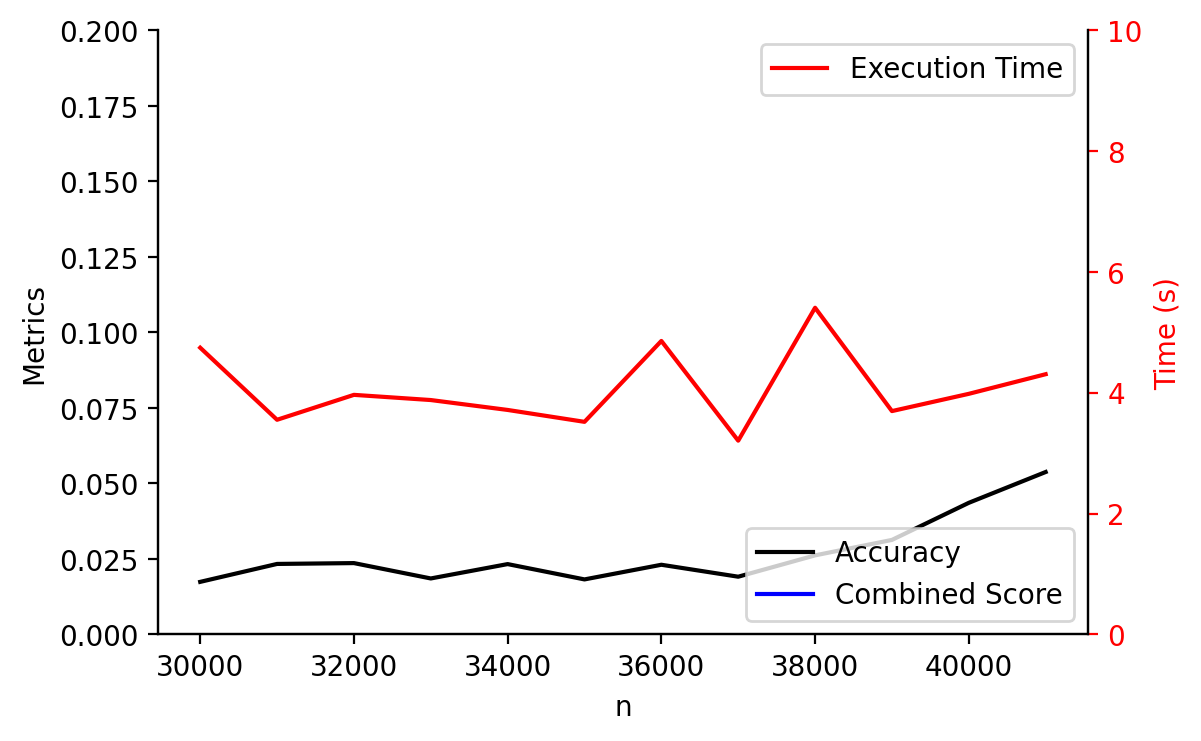

In [11]:
# Plot the first y-axis
parameter_list = [i*1000 for i in range(30,42)]
fig, ax1 = plt.subplots(dpi=200)
ax1.spines['top'].set_visible(False)
#duration estimation accuracy
ax1.plot(parameter_list,A, label='Accuracy', color = "k")
ax1.plot(parameter_list,C, label='Combined Score', color = "blue")

ax1.set_xlabel('n')
ax1.set_ylabel('Metrics', color='k')
ax1.set_ylim([0,0.2])
ax1.tick_params('y', colors='k')
plt.legend(loc= 'lower right')

# Create a second y-axis
ax2 = ax1.twinx()
ax2.plot(parameter_list, T, label="Execution Time", color='r')
ax2.set_ylabel('Time (s)', color='r')
ax2.set_ylim([0,10])
ax2.tick_params('y', colors='r')
ax2.spines['top'].set_visible(False)


plt.legend(loc = 'upper right')
plt.savefig("D:\\data\\playback2T01\\challenge.png", transparent=True,)
plt.show()



In [53]:
C,c,T =[],[],[]
h=1100
n=751
#fmin=37198
for trade_off in [i/1000 for i in range(30,42)]:
    c = []
    for fmin in [i*1000 for i in range(30,42)]:
        combined_score, accuracy_index, execution_time = BetterOptimizationScore({'h' : h, 'n' : n, 'fmin' : fmin}, 
                                                                             X_train=None, y_train=None,
                                                                             reference_df=reference_df,
                                                                             trade_off_factor=trade_off)
        c.append(combined_score)
    C.append(c)

C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'h': 1100, 'n': 751, 'fmin': 30000} -0.020346531506767313


C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'h': 1100, 'n': 751, 'fmin': 31000} -0.02572767262632984


C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'h': 1100, 'n': 751, 'fmin': 32000} -0.025010126237339114


C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'h': 1100, 'n': 751, 'fmin': 33000} -0.021540443139922046


C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'h': 1100, 'n': 751, 'fmin': 34000} -0.0260486975420114


C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'h': 1100, 'n': 751, 'fmin': 35000} -0.02079417575257729


C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'h': 1100, 'n': 751, 'fmin': 36000} -0.02457540093813853


C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'h': 1100, 'n': 751, 'fmin': 37000} -0.019053233977962054


C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'h': 1100, 'n': 751, 'fmin': 38000} -0.026414663134397172


C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'h': 1100, 'n': 751, 'fmin': 39000} -0.030594209924900036


C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'h': 1100, 'n': 751, 'fmin': 40000} -0.037446239028025276


C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'h': 1100, 'n': 751, 'fmin': 41000} -0.052036280359006315


C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'h': 1100, 'n': 751, 'fmin': 30000} -0.020271251377747417


C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'h': 1100, 'n': 751, 'fmin': 31000} -0.02529191374383572


C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'h': 1100, 'n': 751, 'fmin': 32000} -0.02528771363689301


C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'h': 1100, 'n': 751, 'fmin': 33000} -0.02109266955880154


C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'h': 1100, 'n': 751, 'fmin': 34000} -0.02518589315052052


C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'h': 1100, 'n': 751, 'fmin': 35000} -0.019635063025113156


C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'h': 1100, 'n': 751, 'fmin': 36000} -0.025158677789991857


C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'h': 1100, 'n': 751, 'fmin': 37000} -0.01966527323441379


C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'h': 1100, 'n': 751, 'fmin': 38000} -0.026275624415049117


C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'h': 1100, 'n': 751, 'fmin': 39000} -0.0318542201139849


C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'h': 1100, 'n': 751, 'fmin': 40000} -0.036257067041231876


C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'h': 1100, 'n': 751, 'fmin': 41000} -0.051783857987099294


C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'h': 1100, 'n': 751, 'fmin': 30000} -0.020788105816956174


C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'h': 1100, 'n': 751, 'fmin': 31000} -0.028377268762337572


C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'h': 1100, 'n': 751, 'fmin': 32000} -0.026508074713077184


C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'h': 1100, 'n': 751, 'fmin': 33000} -0.02021737936780591


C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'h': 1100, 'n': 751, 'fmin': 34000} -0.02446852813472198


C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'h': 1100, 'n': 751, 'fmin': 35000} -0.01985534054448157


C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'h': 1100, 'n': 751, 'fmin': 36000} -0.02477212498999837


C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'h': 1100, 'n': 751, 'fmin': 37000} -0.01970996428108587


C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'h': 1100, 'n': 751, 'fmin': 38000} -0.025847078256813653


C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'h': 1100, 'n': 751, 'fmin': 39000} -0.03066390229461731


C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'h': 1100, 'n': 751, 'fmin': 40000} -0.03664776931376091


C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'h': 1100, 'n': 751, 'fmin': 41000} -0.051836245811798354


C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'h': 1100, 'n': 751, 'fmin': 30000} -0.021066380071968573


C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'h': 1100, 'n': 751, 'fmin': 31000} -0.02581546435387983


C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'h': 1100, 'n': 751, 'fmin': 32000} -0.02540321443575894


C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'h': 1100, 'n': 751, 'fmin': 33000} -0.02128755932842685


C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'h': 1100, 'n': 751, 'fmin': 34000} -0.025419923589413397


C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'h': 1100, 'n': 751, 'fmin': 35000} -0.02052580670774674


C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'h': 1100, 'n': 751, 'fmin': 36000} -0.025280401669620964


C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'h': 1100, 'n': 751, 'fmin': 37000} -0.019747630466664175


C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'h': 1100, 'n': 751, 'fmin': 38000} -0.028064704945898973


C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'h': 1100, 'n': 751, 'fmin': 39000} -0.03092867499445734


C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'h': 1100, 'n': 751, 'fmin': 40000} -0.03647501812548271


C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'h': 1100, 'n': 751, 'fmin': 41000} -0.05230872255040072


C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'h': 1100, 'n': 751, 'fmin': 30000} -0.02036942028106978


C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'h': 1100, 'n': 751, 'fmin': 31000} -0.02531057603284311


C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'h': 1100, 'n': 751, 'fmin': 32000} -0.025201566798263585


C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'h': 1100, 'n': 751, 'fmin': 33000} -0.020376034100296564


C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'h': 1100, 'n': 751, 'fmin': 34000} -0.025269501407757286


C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'h': 1100, 'n': 751, 'fmin': 35000} -0.020300966547120658


C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'h': 1100, 'n': 751, 'fmin': 36000} -0.027018601654470353


C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'h': 1100, 'n': 751, 'fmin': 37000} -0.019524787972610546


C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'h': 1100, 'n': 751, 'fmin': 38000} -0.02611569559502266


C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'h': 1100, 'n': 751, 'fmin': 39000} -0.03254020133425873


C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'h': 1100, 'n': 751, 'fmin': 40000} -0.036916689649957576


C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'h': 1100, 'n': 751, 'fmin': 41000} -0.051739376243471774


C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'h': 1100, 'n': 751, 'fmin': 30000} -0.020851605698216605


C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'h': 1100, 'n': 751, 'fmin': 31000} -0.025538459104884864


C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'h': 1100, 'n': 751, 'fmin': 32000} -0.02553049982017908


C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'h': 1100, 'n': 751, 'fmin': 33000} -0.020888354092134253


C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'h': 1100, 'n': 751, 'fmin': 34000} -0.025315044306220065


C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'h': 1100, 'n': 751, 'fmin': 35000} -0.021345725678310258


C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'h': 1100, 'n': 751, 'fmin': 36000} -0.025424390371455573


C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'h': 1100, 'n': 751, 'fmin': 37000} -0.019566376538807044


C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'h': 1100, 'n': 751, 'fmin': 38000} -0.02727163702800401


C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'h': 1100, 'n': 751, 'fmin': 39000} -0.03125890330892823


C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'h': 1100, 'n': 751, 'fmin': 40000} -0.036453224436181944


C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'h': 1100, 'n': 751, 'fmin': 41000} -0.05197683705599773


C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'h': 1100, 'n': 751, 'fmin': 30000} -0.020264405586798977


C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'h': 1100, 'n': 751, 'fmin': 31000} -0.025264898726795982


C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'h': 1100, 'n': 751, 'fmin': 32000} -0.02573723523542425


C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'h': 1100, 'n': 751, 'fmin': 33000} -0.020594238349493543


C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'h': 1100, 'n': 751, 'fmin': 34000} -0.02527600595766628


C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'h': 1100, 'n': 751, 'fmin': 35000} -0.020235419187597168


C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'h': 1100, 'n': 751, 'fmin': 36000} -0.025731219493030998


C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'h': 1100, 'n': 751, 'fmin': 37000} -0.02090241595741188


C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'h': 1100, 'n': 751, 'fmin': 38000} -0.027176945335110825


C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'h': 1100, 'n': 751, 'fmin': 39000} -0.031180979043137887


C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'h': 1100, 'n': 751, 'fmin': 40000} -0.03794532752888797


C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'h': 1100, 'n': 751, 'fmin': 41000} -0.0520646523763116


C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'h': 1100, 'n': 751, 'fmin': 30000} -0.02254532391452907


C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'h': 1100, 'n': 751, 'fmin': 31000} -0.0257880462315171


C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'h': 1100, 'n': 751, 'fmin': 32000} -0.0255261621108376


C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'h': 1100, 'n': 751, 'fmin': 33000} -0.020490729318368574


C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'h': 1100, 'n': 751, 'fmin': 34000} -0.025280758344528052


C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'h': 1100, 'n': 751, 'fmin': 35000} -0.020711688382926065


C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'h': 1100, 'n': 751, 'fmin': 36000} -0.025576063691969624


C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'h': 1100, 'n': 751, 'fmin': 37000} -0.021364261899809497


C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'h': 1100, 'n': 751, 'fmin': 38000} -0.02676318213583127


C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'h': 1100, 'n': 751, 'fmin': 39000} -0.031502152461951566


C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'h': 1100, 'n': 751, 'fmin': 40000} -0.03673356983694948


C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'h': 1100, 'n': 751, 'fmin': 41000} -0.052156212668911406


C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'h': 1100, 'n': 751, 'fmin': 30000} -0.020906306361057263


C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'h': 1100, 'n': 751, 'fmin': 31000} -0.02734702253302348


C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'h': 1100, 'n': 751, 'fmin': 32000} -0.028191899230910835


C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'h': 1100, 'n': 751, 'fmin': 33000} -0.023776682729784015


C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'h': 1100, 'n': 751, 'fmin': 34000} -0.02668364740407878


C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'h': 1100, 'n': 751, 'fmin': 35000} -0.020803005709201336


C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'h': 1100, 'n': 751, 'fmin': 36000} -0.02514441222782049


C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'h': 1100, 'n': 751, 'fmin': 37000} -0.020403150663835058


C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'h': 1100, 'n': 751, 'fmin': 38000} -0.026547274743614117


C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'h': 1100, 'n': 751, 'fmin': 39000} -0.0312833719016716


C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'h': 1100, 'n': 751, 'fmin': 40000} -0.036500778843728716


C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'h': 1100, 'n': 751, 'fmin': 41000} -0.052701243583047244


C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'h': 1100, 'n': 751, 'fmin': 30000} -0.020741942407452637


C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'h': 1100, 'n': 751, 'fmin': 31000} -0.02621285736699419


C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'h': 1100, 'n': 751, 'fmin': 32000} -0.025909653801316712


C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'h': 1100, 'n': 751, 'fmin': 33000} -0.020582783400755103


C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'h': 1100, 'n': 751, 'fmin': 34000} -0.025626625270208866


C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'h': 1100, 'n': 751, 'fmin': 35000} -0.02138586648149078


C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'h': 1100, 'n': 751, 'fmin': 36000} -0.025282864113641706


C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'h': 1100, 'n': 751, 'fmin': 37000} -0.01987915135002508


C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'h': 1100, 'n': 751, 'fmin': 38000} -0.026394615081879833


C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'h': 1100, 'n': 751, 'fmin': 39000} -0.031028960713147445


C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'h': 1100, 'n': 751, 'fmin': 40000} -0.036764956646512054


C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'h': 1100, 'n': 751, 'fmin': 41000} -0.05251654355304778


C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'h': 1100, 'n': 751, 'fmin': 30000} -0.021642943063751374


C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'h': 1100, 'n': 751, 'fmin': 31000} -0.025849403281316775


C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'h': 1100, 'n': 751, 'fmin': 32000} -0.026809991718018296


C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'h': 1100, 'n': 751, 'fmin': 33000} -0.021711690344659924


C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'h': 1100, 'n': 751, 'fmin': 34000} -0.025784549897399072


C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'h': 1100, 'n': 751, 'fmin': 35000} -0.020931262129792322


C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'h': 1100, 'n': 751, 'fmin': 36000} -0.02535316547202124


C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'h': 1100, 'n': 751, 'fmin': 37000} -0.020701307850485576


C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'h': 1100, 'n': 751, 'fmin': 38000} -0.027600104507396674


C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'h': 1100, 'n': 751, 'fmin': 39000} -0.03198147803400812


C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'h': 1100, 'n': 751, 'fmin': 40000} -0.03833945793676223


C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'h': 1100, 'n': 751, 'fmin': 41000} -0.053274824915638286


C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'h': 1100, 'n': 751, 'fmin': 30000} -0.022062406545227432


C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'h': 1100, 'n': 751, 'fmin': 31000} -0.026791216992226946


C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'h': 1100, 'n': 751, 'fmin': 32000} -0.027048824369697494


C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'h': 1100, 'n': 751, 'fmin': 33000} -0.0226720038285102


C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'h': 1100, 'n': 751, 'fmin': 34000} -0.025935078591665776


C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'h': 1100, 'n': 751, 'fmin': 35000} -0.02094595310187853


C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'h': 1100, 'n': 751, 'fmin': 36000} -0.02694498585082296


C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'h': 1100, 'n': 751, 'fmin': 37000} -0.01972200289629838


C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'h': 1100, 'n': 751, 'fmin': 38000} -0.02670581362958473


C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'h': 1100, 'n': 751, 'fmin': 39000} -0.032805853478391885


C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'h': 1100, 'n': 751, 'fmin': 40000} -0.03697705978917923


C:\ProgramData\Anaconda3\lib\site-packages\libf0\salience.py:440: RuntimeWarning: invalid value encountered in cast
  bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\de Witasse Thézy\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'h': 1100, 'n': 751, 'fmin': 41000} -0.05265060129905248


NameError: name 'parameter_list' is not defined

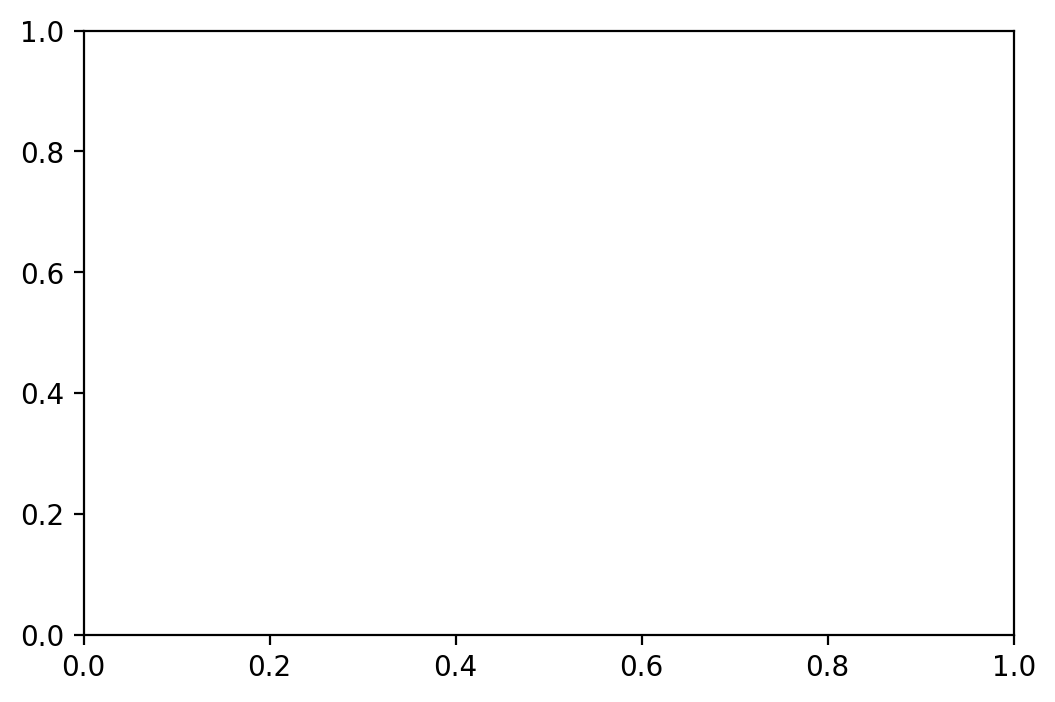

In [6]:

fig, ax = plt.subplots(dpi=200)
trade_off_list = [i/1000 for i in range(30,42)]

for i in range(1, 9):
    trade_off = trade_off_list[i]
    color = plt.cm.viridis(trade_off)  # Use a colormap to determine color based on trade_off
    plt.plot(parameter_list, C[i], label=f'Combined Score (Trade-off={trade_off})', color=color)

plt.xlabel('n')
plt.ylabel('Metric')

# Add color bar
sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=min(trade_off_list), vmax=max(trade_off_list)))
sm.set_array([])  # You need to set an empty array to get the color mapping right
cbar = plt.colorbar(sm, ax=ax, label='Trade-off')

# Save the figure
plt.savefig("D:\\data\\playback2T01\\CombinedScore.png", transparent=True)
plt.show()

In [55]:
[i*100 for i in range(1,11)]


[100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]